# Közlekedési hálózatok vizsgálata
## Szeged városi tömegközlekedés

TramTrain kivételével

In [1]:
import networkx as nx
import peartree as pt
import matplotlib.pyplot as plt
import osmnx as ox

### Szeged tömegközlekedései adatok beolvasása

In [2]:
### np.unicode is deprecated after version 1.20.0 and removed in 1.24.0
#import numpy as np
#
#np.unicode = np.unicode_

### pd.Seried.iteritems() is deprecated after version 1.5.0 and removed in 2.0
import pandas as pd

def iteritems(self):
  yield from self.items()
pd.Series.iteritems = iteritems

#path = './gtfs-1.zip' #összes
#path = './gtfs-11.zip' #bartók
path = './gtfs-0.zip' #centrum
feed = pt.get_representative_feed(path)

start = 7*60*60  # 7:00 AM
end = 10*60*60  # 10:00 AM

G = pt.load_feed_as_graph(feed, start, end)

### Szeged ábrázolása

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

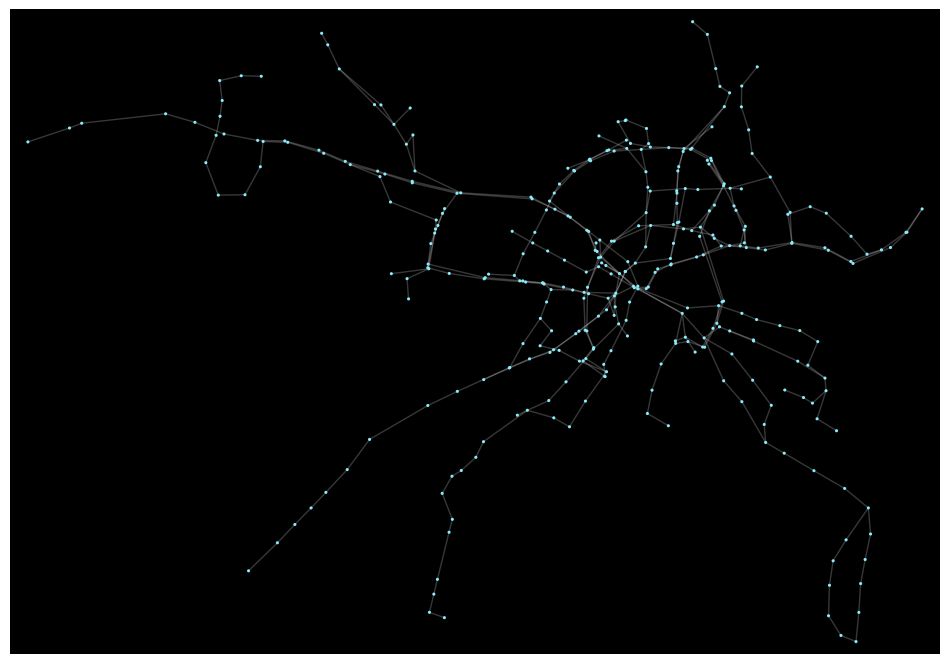

In [5]:
pt.plot.generate_plot(G)

### Edge betweenness ábrázolása

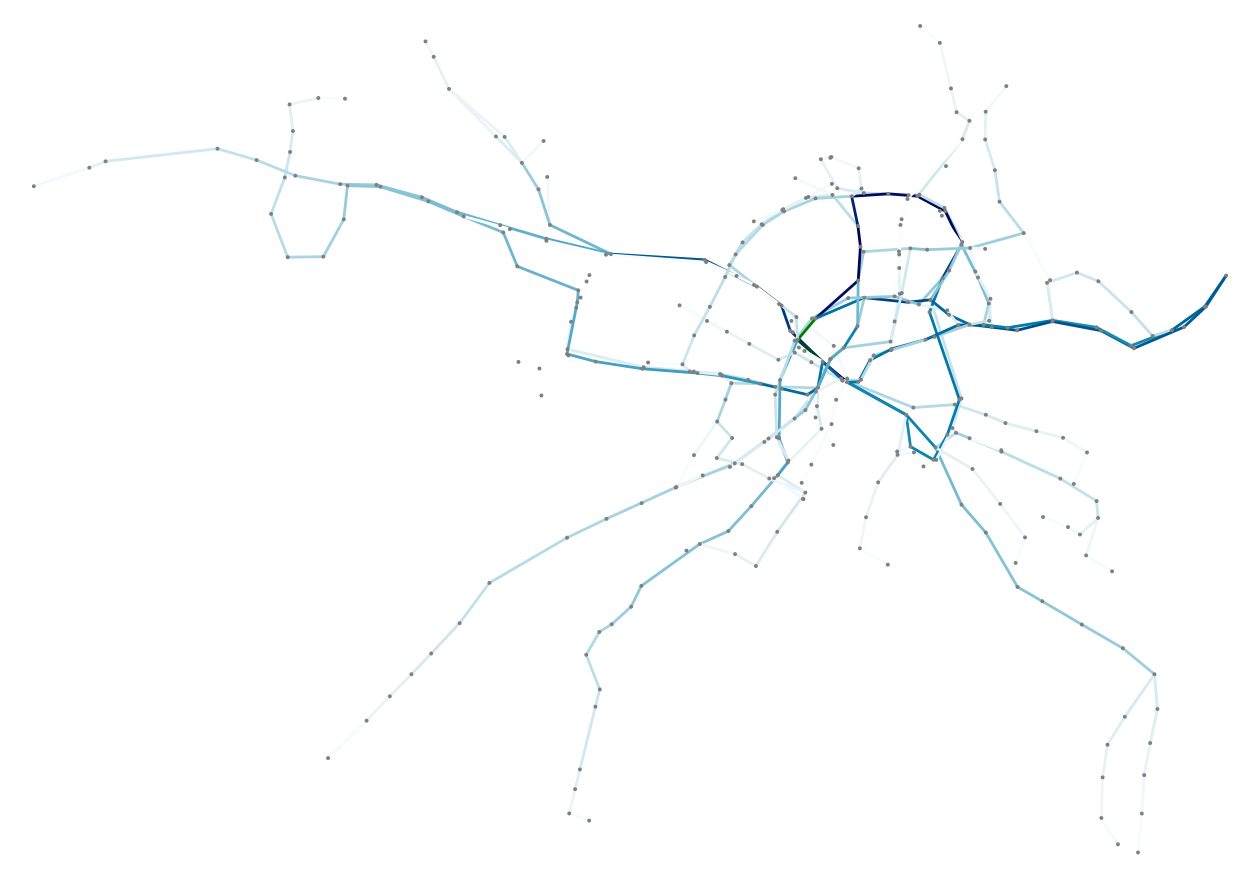

In [10]:
bc = nx.edge_betweenness_centrality(G)
nx.set_edge_attributes(G, bc, "weight")

ec = ox.plot.get_edge_colors_by_attr(G, "weight", cmap="ocean_r")

fig, ax = ox.plot_graph(
    G,
    node_color="gray",
    edge_color=ec,
    node_size=8,
    edge_linewidth=2,
    figsize=(16,16),
    dpi=100,
    bgcolor="white"
)

Minél sötétebb egy él, annál nagyobb az edge betweenness értéke azaz a központisága.

### Gráf egyszerűsítése és edge betweenness

In [3]:
G_proj = ox.project_graph(G)
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=60, dead_ends=False)

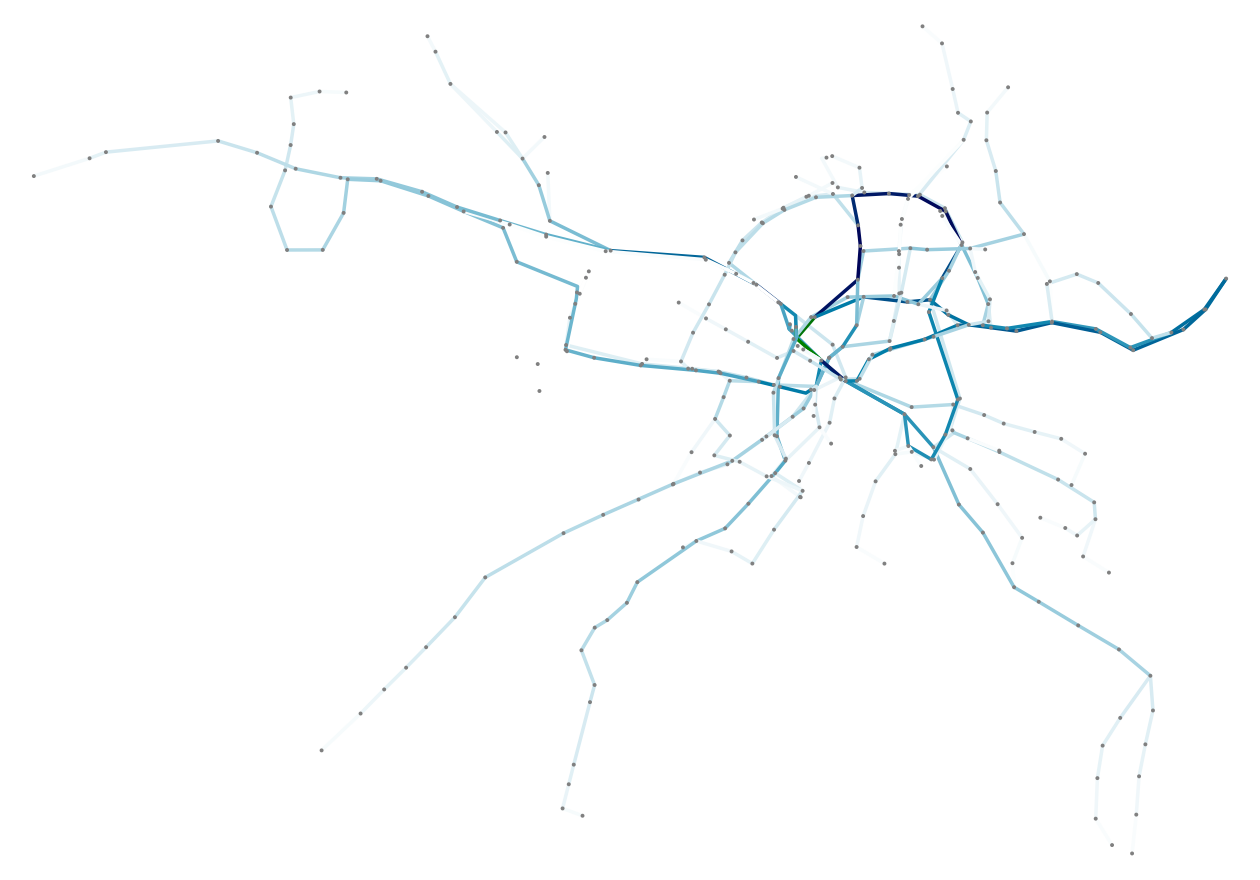

In [152]:
bc = nx.edge_betweenness_centrality(G2)
nx.set_edge_attributes(G2, bc, "weight")

ec = ox.plot.get_edge_colors_by_attr(G2, "weight", cmap="ocean_r")

fig, ax = ox.plot_graph(
    G2,
    node_color="gray",
    edge_color=ec,
    node_size=8,
    edge_linewidth=2.5,
    figsize=(16,16),
    dpi=100,
    bgcolor="white"
)

### Minimális feszítőfa ábrázolása

In [4]:
S = G2.to_undirected()

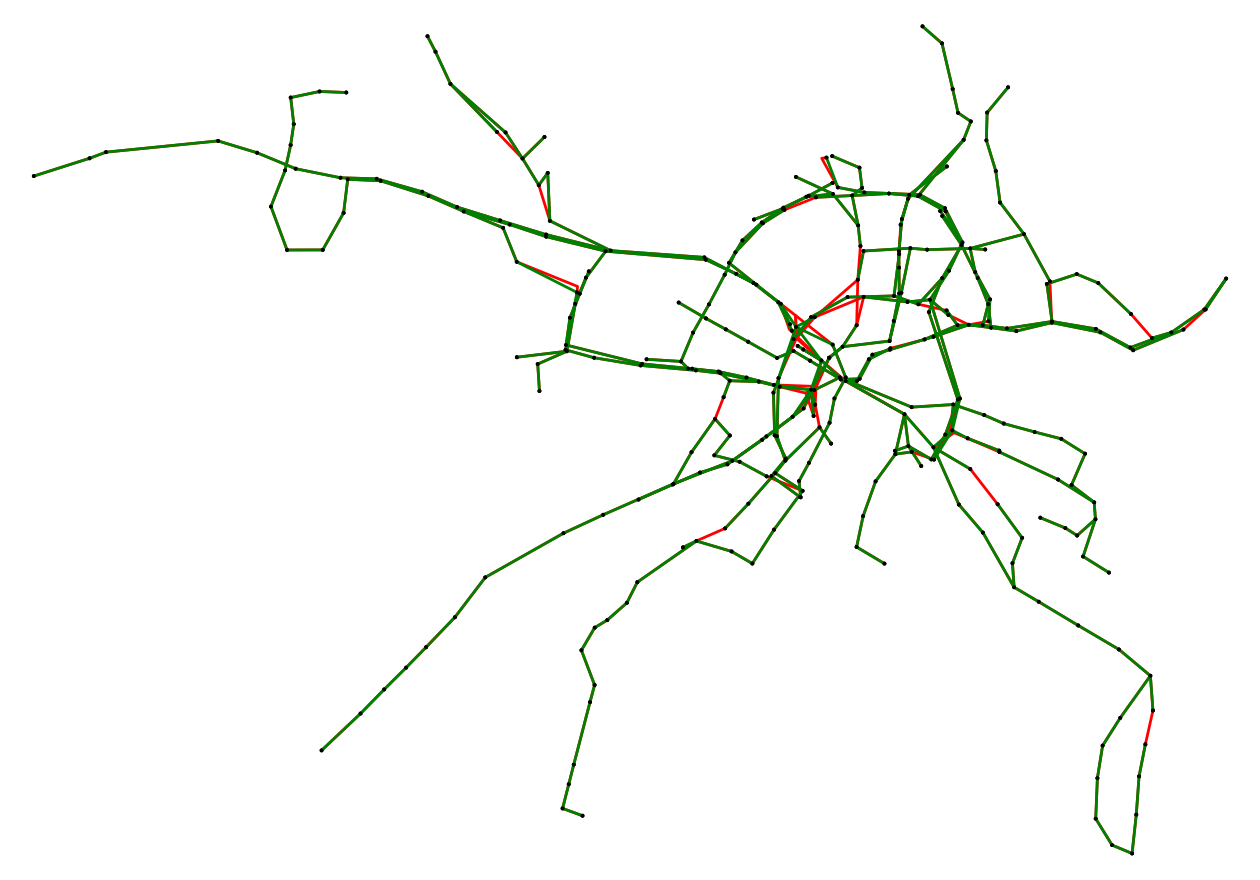

In [6]:
mst = nx.minimum_spanning_tree(S)

# Plot the original graph to serve as the base
fig, ax = ox.plot_graph(
    S,
    node_color="black",
    edge_color='red', 
    node_size=8,
    edge_linewidth=2,
    figsize=(16,16),
    dpi=100,
    bgcolor="white", 
    show=False
)


# Plot the spanning tree edges with a different color
ox.plot_graph(ox.project_graph(mst),
    node_color="black", edge_color='green', node_size=8,
    edge_linewidth=2,
    figsize=(16,16), dpi=100,
    bgcolor="white",
    ax=ax,
    show=False
)

# Show the plot
plt.show()

### Random feszítőfa ábrázolása

In [12]:
tree = nx.random_spanning_tree(S, None)
treee = nx.MultiGraph(tree)

In [14]:
treee.graph['crs'] = S.graph['crs']
#treee.nodes = S.nodes(data=True)

In [ ]:
ox.graph_to_gdfs(treee, node_geometry=True)

In [15]:
for node in S.nodes(data=True):
    node_id, data = node
    if treee.has_node(node_id):
        treee.nodes[node_id].update(data)

In [48]:
##edges_to_color = [(u, v) for u, v, data in S.edges(data=True) if (u, v) in tree.edges(data=True)]
##edge_colors = ['orange' if (u, v) in edges_to_color else 'k' for u, v in S.edges()]

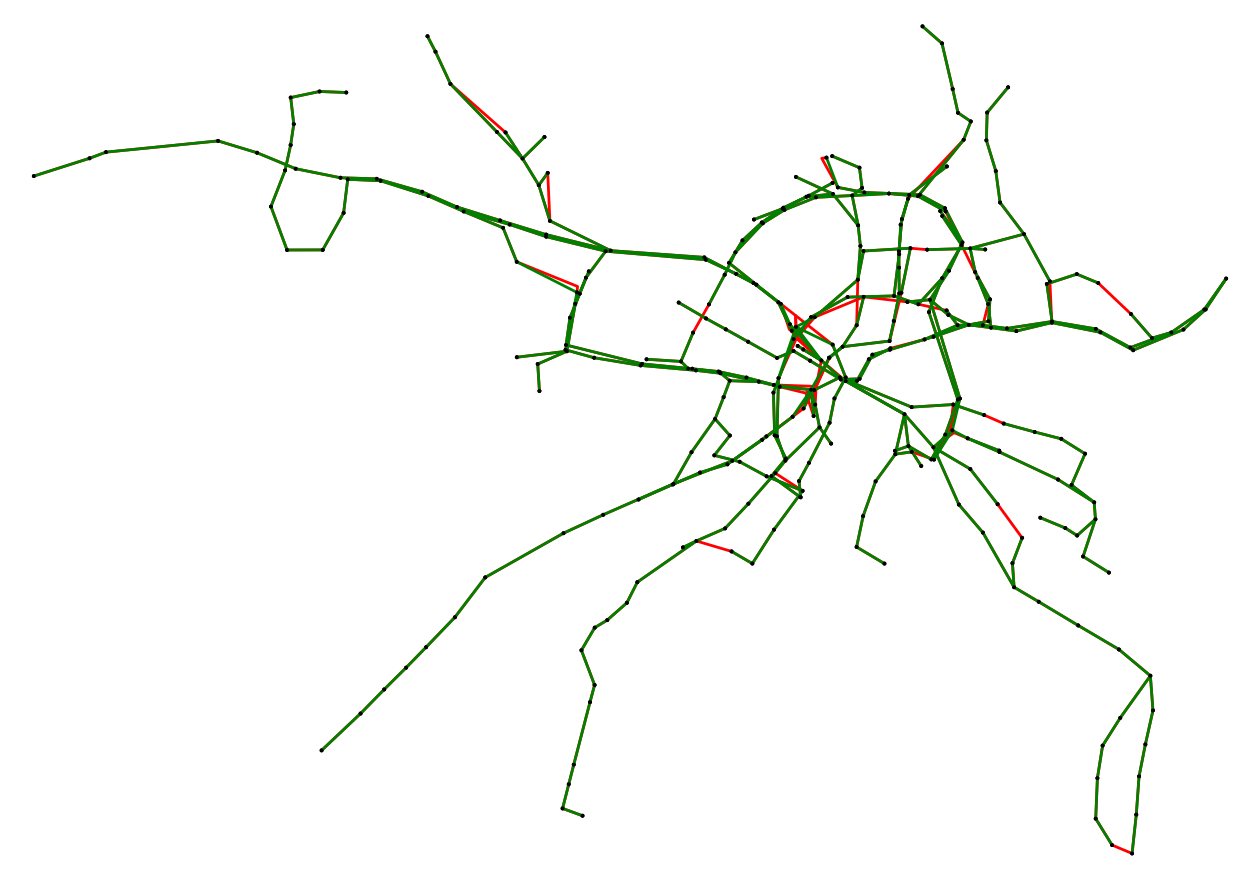

In [37]:
# Plot the original graph to serve as the base
fig, ax = ox.plot_graph(
    S,
    node_color="black",
    edge_color='red', 
    node_size=8,
    edge_linewidth=2,
    figsize=(16,16),
    dpi=100,
    bgcolor="white", 
    show=False
)


# Plot the spanning tree edges with a different color
ox.plot_graph(ox.project_graph(treee),
    node_color="black", edge_color='green', node_size=8,
    edge_linewidth=2,
    figsize=(16,16), dpi=100,
    bgcolor="white",
    ax=ax,
    show=False
)

# Show the plot
plt.show()

### ~~Community detection~~

In [49]:
communities_generator = nx.community.girvan_newman(S)
k = 1
comm = {}
while(k<5):
   comm = next(communities_generator)
   k += 1

#sorted(map(sorted, next_level_communities))

In [50]:
partition_sizes = []

for i in range(len(comm)):
    partition_sizes.append(round(len(comm[i]) / len(S.nodes) * 100))

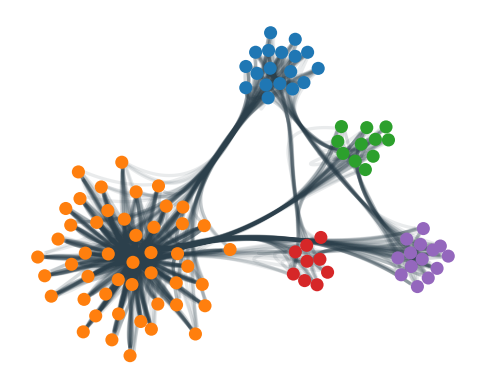

In [55]:
from netgraph import Graph

# create a modular graph
g = nx.random_partition_graph(partition_sizes, 0.5, 0.1)

# since we created the graph, we know the best partition:
node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1
        
# alternatively, we can infer the best partition using Louvain:
from community import community_louvain

node_to_community = community_louvain.best_partition(g)

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:purple',
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(g,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1, node_size = 2, edge_width=0.5,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)

plt.show()